<a href="https://colab.research.google.com/github/NismaK/AI_Assisted_Early_Prediction_and_Severity_Classification_of_KOA/blob/main/KOA_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎓 FINAL YEAR PROJECT
## Project Title

**AI-Assisted Early Prediction and Severity Classification of Knee Osteoarthritis Using YOLO-Enhanced CNN Models**

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip /content/drive/MyDrive/'KOA classification dataset'/'Radiographicimages.zip' -d /content/KOA_Data


Streaming output truncated to the last 5000 lines.
  inflating: /content/KOA_Data/train/0/9684605R.png  
  inflating: /content/KOA_Data/train/0/9685238L.png  
  inflating: /content/KOA_Data/train/0/9685238R.png  
  inflating: /content/KOA_Data/train/0/9686617L.png  
  inflating: /content/KOA_Data/train/0/9686617R.png  
  inflating: /content/KOA_Data/train/0/9686777R.png  
  inflating: /content/KOA_Data/train/0/9686834L.png  
  inflating: /content/KOA_Data/train/0/9686834R.png  
  inflating: /content/KOA_Data/train/0/9686908L.png  
  inflating: /content/KOA_Data/train/0/9686908R.png  
  inflating: /content/KOA_Data/train/0/9687273L.png  
  inflating: /content/KOA_Data/train/0/9689906R.png  
  inflating: /content/KOA_Data/train/0/9690910L.png  
  inflating: /content/KOA_Data/train/0/9690910R.png  
  inflating: /content/KOA_Data/train/0/9691359L.png  
  inflating: /content/KOA_Data/train/0/9691359R.png  
  inflating: /content/KOA_Data/train/0/9692163L.png  
  inflating: /content/KOA_Data/

In [3]:
!ls /content/KOA_Data



auto_test  test  train	val


In [4]:
!ls /content/KOA_Data/train


0  1  2  3  4


In [5]:
# Install necessary libraries
!pip install ultralytics torch torchvision opencv-python scikit-learn matplotlib pillow grad-cam --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 82.2 MB/s eta 0:00:00


In [6]:
# Import libraries
import torch, cv2, os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
from ultralytics import YOLO


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [7]:
dataset_path = "/content/KOA_Data"

In [8]:
preprocessed_dir = "/content/KOA_Data_preprocessed"
os.makedirs(preprocessed_dir, exist_ok=True)

for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(preprocessed_dir, split), exist_ok=True)
    for cls in os.listdir(os.path.join(dataset_path, split)):
        os.makedirs(os.path.join(preprocessed_dir, split, cls), exist_ok=True)
        for img_name in os.listdir(os.path.join(dataset_path, split, cls)):
            img_path = os.path.join(dataset_path, split, cls, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            # CLAHE contrast enhancement
            clahe = cv2.createCLAHE(2.0, (8,8))
            img = clahe.apply(img)

            # Resize to YOLO size (640x640)
            img = cv2.resize(img, (640, 640))

            save_path = os.path.join(preprocessed_dir, split, cls, img_name)
            cv2.imwrite(save_path, img)



image 1/1 /content/KOA_Data_preprocessed/train/0/9001695L.png: 640x640 1 person, 11.6ms
Speed: 8.4ms preprocess, 11.6ms inference, 36.0ms postprocess per image at shape (1, 3, 640, 640)


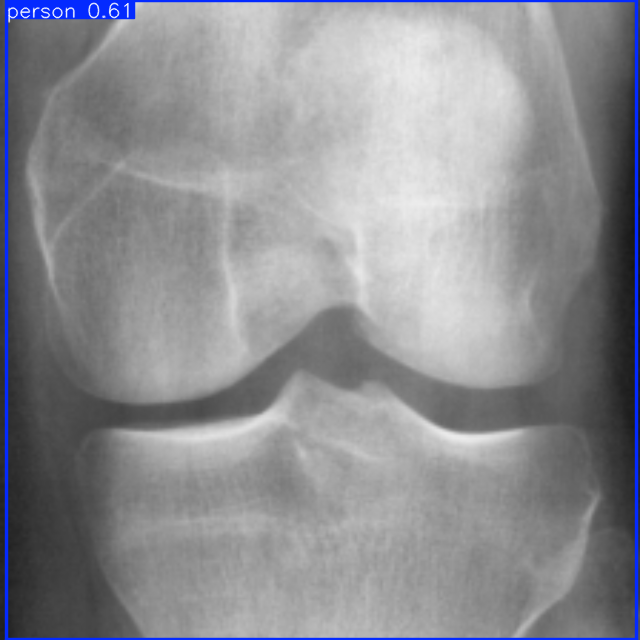

In [9]:
from ultralytics import YOLO

yolo_model = YOLO("yolov8n.pt")
img_test = "/content/KOA_Data_preprocessed/train/0/9001695L.png"

results = yolo_model(img_test)  # returns a list
results[0].show()               # access the first Results object



In [2]:
preprocessed_dir="/content/KOA_Data_preprocessed"

In [7]:
from glob import glob
import os
import cv2
from tqdm import tqdm
from ultralytics import YOLO

# 1️⃣ Load YOLO model
yolo_model = YOLO("yolov8n.pt")  # must be loaded in every session

preprocessed_dir = "/content/KOA_Data_preprocessed"
roi_dir = "/content/KOA_Data_ROI"
os.makedirs(roi_dir, exist_ok=True)

batch_size = 8
imgsz = 416

for split in ["train", "val", "test"]:
    for cls in os.listdir(os.path.join(preprocessed_dir, split)):
        os.makedirs(os.path.join(roi_dir, split, cls), exist_ok=True)
        img_paths = glob(os.path.join(preprocessed_dir, split, cls, "*.png"))

        for i in tqdm(range(0, len(img_paths), batch_size)):
            batch_paths = img_paths[i:i+batch_size]

            try:
                results = yolo_model.predict(
                    source=batch_paths,
                    imgsz=imgsz,
                    save=False,
                    verbose=False
                )

                for res, img_path in zip(results, batch_paths):
                    img = cv2.imread(img_path)
                    if len(res.boxes) > 0:
                        x1, y1, x2, y2 = map(int, res.boxes.xyxy[0])
                        roi = img[y1:y2, x1:x2]
                    else:
                        roi = img  # fallback if no box
                    roi = cv2.resize(roi, (224,224))
                    save_path = os.path.join(roi_dir, split, cls, os.path.basename(img_path))
                    cv2.imwrite(save_path, roi)

            except Exception as e:
                print(f"Error processing batch {i}-{i+batch_size}: {e}")


100%|██████████| 80/80 [00:14<00:00,  5.55it/s]


In [9]:
import torch
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"

# 1️⃣ Data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# 2️⃣ Load ROI datasets
train_data = ImageFolder("/content/KOA_Data_ROI/train", transform=transform)
val_data   = ImageFolder("/content/KOA_Data_ROI/val", transform=transform)
test_data  = ImageFolder("/content/KOA_Data_ROI/test", transform=transform)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=16)
test_loader  = DataLoader(test_data, batch_size=16)

# 3️⃣ DenseNet-169 model
model = models.densenet169(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, 5)  # 5 classes: 0-4
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 4️⃣ Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

# 5️⃣ Save model
torch.save(model.state_dict(), "/content/densenet169_koa.pth")
print("DenseNet-169 training complete!")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth


100%|██████████| 54.7M/54.7M [00:00<00:00, 180MB/s]


Epoch 1/10, Loss: 1.0451
Epoch 2/10, Loss: 0.7689
Epoch 3/10, Loss: 0.5868
Epoch 4/10, Loss: 0.4188
Epoch 5/10, Loss: 0.2492
Epoch 6/10, Loss: 0.1754
Epoch 7/10, Loss: 0.1382
Epoch 8/10, Loss: 0.1548
Epoch 9/10, Loss: 0.1182
Epoch 10/10, Loss: 0.0919
DenseNet-169 training complete!


In [10]:
from sklearn.metrics import accuracy_score, classification_report

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Test Accuracy:", accuracy_score(all_labels, all_preds))
print(classification_report(all_labels, all_preds))


Test Accuracy: 0.6068840579710145
              precision    recall  f1-score   support

           0       0.74      0.70      0.72       639
           1       0.26      0.21      0.23       296
           2       0.55      0.62      0.58       447
           3       0.72      0.78      0.75       223
           4       0.68      0.86      0.76        51

    accuracy                           0.61      1656
   macro avg       0.59      0.63      0.61      1656
weighted avg       0.60      0.61      0.60      1656



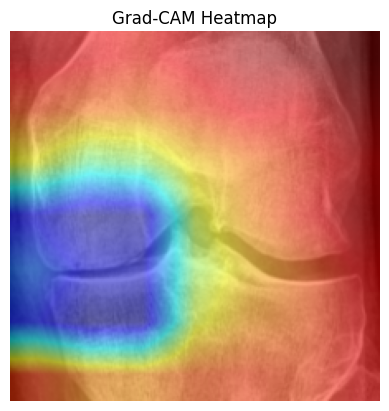

In [12]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import cv2
import torch

# Target layer for DenseNet
target_layer = model.features[-1]
cam = GradCAM(model=model, target_layers=[target_layer])

# Sample image
img_path = "/content/KOA_Data_ROI/test/3/9011053L.png"
img = cv2.imread(img_path)
img_rgb = cv2.resize(img, (224,224))/255.0
# Explicitly convert the input tensor to float32
input_tensor = torch.tensor(img_rgb).permute(2,0,1).unsqueeze(0).float().to(device)

# Generate Grad-CAM
grayscale_cam = cam(input_tensor=input_tensor)[0]
cam_image = show_cam_on_image(img_rgb, grayscale_cam)

plt.imshow(cam_image)
plt.axis('off')
plt.title("Grad-CAM Heatmap")
plt.show()